# 03-02 : Few-Shot Classification 

## References

- [SetFit for Multilabel Text Classification](https://github.com/huggingface/setfit/blob/main/notebooks/text-classification_multilabel.ipynb)
- [mteb/leaderboard](https://huggingface.co/spaces/mteb/leaderboard)
- [Alibaba-NLP/gte-large-en-v1.5](https://huggingface.co/Alibaba-NLP/gte-large-en-v1.5)

In [1]:
import pandas as pd
import numpy as np
from typing import List
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, jaccard_score, accuracy_score, f1_score
from datasets import Dataset
from setfit import get_templated_dataset
from setfit import SetFitModel, Trainer, TrainingArguments

2024-05-20 21:00:14.864420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 21:00:14.864447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 21:00:14.865327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-20 21:00:14.869431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 21:00:15.451140: W tensorflow/compiler/tf2

In [2]:
data_path = '../../data'
input_path = f'{data_path}/input/labelled_tweets/csv_labels'
train_input_file = f'{input_path}/train.csv'
test_input_file = f'{input_path}/test.csv'
val_input_file = f'{input_path}/val.csv'

## 1. Load Data

In [3]:
df_train = pd.read_csv(train_input_file)
df_val = pd.read_csv(val_input_file)
df_test = pd.read_csv(test_input_file)

## 2. Preprocessing

### 2.1. Labels to List

In [4]:
df_train['labels_list'] = df_train['labels'].str.split(' ')
df_test['labels_list'] = df_test['labels'].str.split(' ')
df_val['labels_list'] = df_val['labels'].str.split(' ')

### 2.2. Multi-label Binarization

In [5]:
# get the list of label values
labels = pd.concat([df_train.labels_list, 
                    df_val.labels_list, 
                    df_test.labels_list])

# initialize MultiLabelBinarizer
labels_lookup = MultiLabelBinarizer()

# learn the vocabulary
labels_lookup = labels_lookup.fit(labels)

# show the vocabulary
vocab = labels_lookup.classes_
print(f'Vocabulary size: {len(vocab)}')
print(f'Vocabulary: {vocab}')


Vocabulary size: 12
Vocabulary: ['conspiracy' 'country' 'ineffective' 'ingredients' 'mandatory' 'none'
 'pharma' 'political' 'religious' 'rushed' 'side-effect' 'unnecessary']


In [6]:
# update the data frame with a `labels_encoded` column
df_train['labels_encoded'] = labels_lookup.transform(df_train.labels_list).tolist()
df_val['labels_encoded'] = labels_lookup.transform(df_val.labels_list).tolist()
df_test['labels_encoded'] = labels_lookup.transform(df_test.labels_list).tolist()

In [7]:
# add the one-hot encoded labels as columns to the data frames
df_train = df_train.join(pd.DataFrame(labels_lookup.transform(df_train.labels_list), 
                                     columns=labels_lookup.classes_, 
                                     index=df_train.index))

df_val = df_val.join(pd.DataFrame(labels_lookup.transform(df_val.labels_list),
                                    columns=labels_lookup.classes_,
                                    index=df_val.index))

df_test = df_test.join(pd.DataFrame(labels_lookup.transform(df_test.labels_list),
                                    columns=labels_lookup.classes_,
                                    index=df_test.index))

## 3. Model Training

In [8]:
random_seed = 42

In [9]:
#model_name = 'BAAI/bge-small-en-v1.5'
model_name = 'sentence-transformers/paraphrase-mpnet-base-v2'

### 3.1. Create Model

In [10]:
# load the model from the Hugging Face model hub
model = SetFitModel.from_pretrained(
    model_name,
    multi_target_strategy="one-vs-rest")

# model = SetFitModel.from_pretrained(
#     model_name,
#     multi_target_strategy="one-vs-rest",
#     use_differentiable_head=True,
#     head_params={"out_features": len(vocab)},
# )

/home/johnny/swan/miniconda3/envs/caves-data/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


### 3.2 Select Training Data

In [11]:
num_samples = 16
df_sample = pd.DataFrame()

# select the sample rows for each category
for label in vocab:
    # get the sample rows for the label
    sample_rows = df_train[df_train[label] == 1].sample(
        n=num_samples, 
        random_state=random_seed)[['text', 'labels_encoded']]
    
    # append the sample rows to the data frame
    df_sample = pd.concat([df_sample, sample_rows])

In [12]:
# create the training dataset
train_dataset = Dataset.from_pandas(df_sample, preserve_index=False)
train_dataset

Dataset({
    features: ['text', 'labels_encoded'],
    num_rows: 192
})

### 3.3. Create Trainer

In [13]:
# create the trainer
trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    metric="accuracy",
    column_mapping={
        'text' : 'text',
        'labels_encoded' : 'label'
    },
    args=TrainingArguments(
        num_epochs=2)
)

Applying column mapping to the training dataset
/home/johnny/swan/miniconda3/envs/caves-data/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/johnny/swan/miniconda3/envs/caves-data/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


Map:   0%|          | 0/192 [00:00<?, ? examples/s]

### 3.4. Train the model

In [14]:
trainer.train()

***** Running training *****
  Num unique pairs = 30244
  Batch size = 16
  Num epochs = 2
  Total optimization steps = 3782


Step,Training Loss


## 4. Make Predictions

In [15]:
data = df_test

In [16]:
def get_predictions(texts, model, labels):
    probas = model.predict_proba(texts, as_numpy=True)
    return probas.tolist()
    # for pred in probas:
    #     yield [{"label": label, "score": score} for label, score in zip(labels, pred)]

In [17]:
y_true = data.labels_encoded.tolist()
y_pred = list(get_predictions(data.text.values, model, vocab.tolist()))
#y_pred[:5]

## 5. Evaluation Metrics

In [18]:
def calculate_metric(metric_func, y_true:List[List[int]], y_pred_proba:List[List[float]], threshold:float, **kwargs):
    # Convert predictions to binary
    y_pred = [[int(prob > threshold) for prob in pred] for pred in y_pred_proba]

    # return the subset accuracy
    return metric_func(y_true, y_pred, **kwargs)

def f1_score_macro(y_true:List[List[int]], y_pred_proba:List[List[float]], threshold:float=0.5):
    """Calculate F1 Score (Macro)."""
    return calculate_metric(f1_score, y_true, y_pred_proba, threshold, average='macro')

def f1_score_weighted(y_true:List[List[int]], y_pred_proba:List[List[float]], threshold:float=0.5):
    """Calculate F1-score (Weighted-Average)."""
    return calculate_metric(f1_score, y_true, y_pred_proba, threshold, average='weighted')

def jaccard_similarity(y_true:List[List[int]], y_pred_proba:List[List[float]], threshold:float=0.5):
    """Calculate average Jaccard Similarity."""
    return calculate_metric(jaccard_score, y_true, y_pred_proba, threshold, average='samples')

def subset_accuracy(y_true:List[List[int]], y_pred_proba:List[List[float]], threshold:float=0.5):
    """Calculate Subset Accuracy (Exact Match Accuracy)."""
    return calculate_metric(accuracy_score, y_true, y_pred_proba, threshold)

In [19]:
def evaluate_all(y_true,
                 y_pred_proba,
                 threshold:float=0.5):

    """Evaluate all metrics and display a summary."""
    f1_macro_score = f1_score_macro(y_true, y_pred_proba, threshold)
    f1_weighted_score = f1_score_weighted(y_true, y_pred_proba,threshold)
    jaccard_similarity_score = jaccard_similarity(y_true, y_pred_proba, threshold)
    subset_accuracy_score = subset_accuracy(y_true, y_pred_proba, threshold)

    # Display a summary of the evaluation
    print(f"F1 Score (Macro-Average)   \t{f1_macro_score:.3f}")
    print(f"F1 Score (Weighted-Average)\t{f1_weighted_score:.3f}")
    print(f"Average Jaccard Similarity \t{jaccard_similarity_score:.3f}")
    print(f"Subset Accuracy            \t{subset_accuracy_score:.3f}")

## 6. Optimize Threshold

In [20]:
def optimize_score(metric_func, y_true:List[List[int]], y_pred_proba:List[List[float]]):
    """Optimize the threshold for a given metric."""
    scores = []
    
    # get the scores for different thresholds
    for threshold in np.arange(0.0, 1.0, 0.01):
        score = metric_func(y_true, y_pred, threshold)
        scores.append({
            'threshold': threshold,
            'score': score
        })
        
    # convert to DataFrame
    df_scores = pd.DataFrame(scores)
    
    # find the threshold with the highest F1 score
    best_threshold = df_scores.loc[df_scores['score'].idxmax()]['threshold']
    best_score = df_scores['score'].max()
    print(f"Best Threshold: {best_threshold:.2f}")
    print(f"Best Score: {best_score:.3f}")
    
    # plot the F1 scores
    plt.plot(df_scores['threshold'], df_scores['score'])
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'{metric_func.__name__} vs. Threshold')
    plt.show()
    
    return best_threshold 

### 6.1. F1 Score (Macro-Average)

Best Threshold: 0.47
Best Score: 0.515


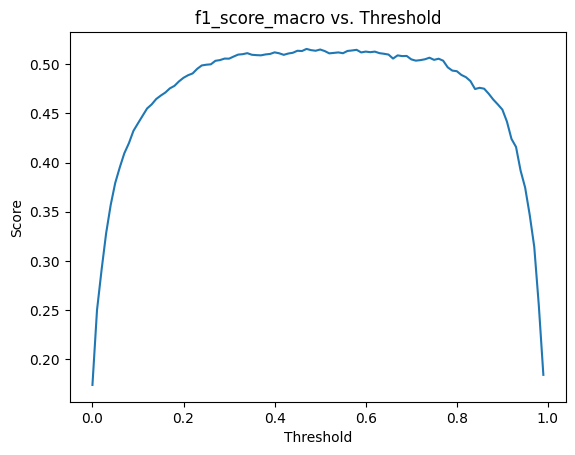

0.47000000000000003

In [21]:
optimize_score(f1_score_macro, y_true, y_pred)

### 6.2. F1 Score (Weighted-Average)

Best Threshold: 0.46
Best Score: 0.591


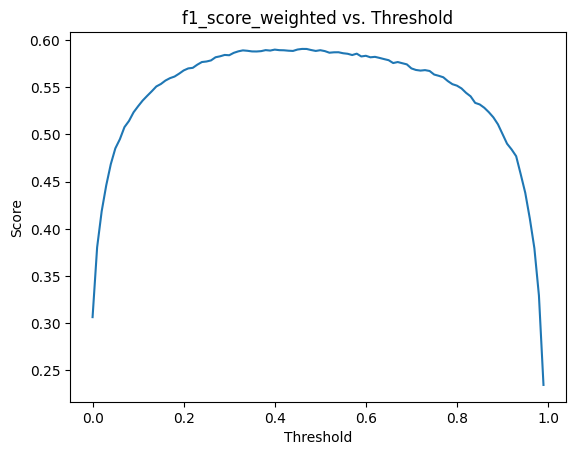

0.46

In [22]:
optimize_score(f1_score_weighted, y_true, y_pred)

### 6.3. Average Jaccard Similarity

Best Threshold: 0.58
Best Score: 0.524


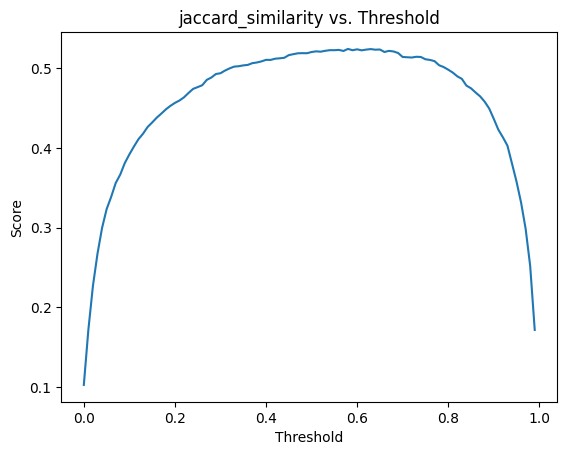

0.58

In [23]:
optimize_score(jaccard_similarity, y_true, y_pred)

### 6.4 Subset Accuracy 

Best Threshold: 0.77
Best Score: 0.409


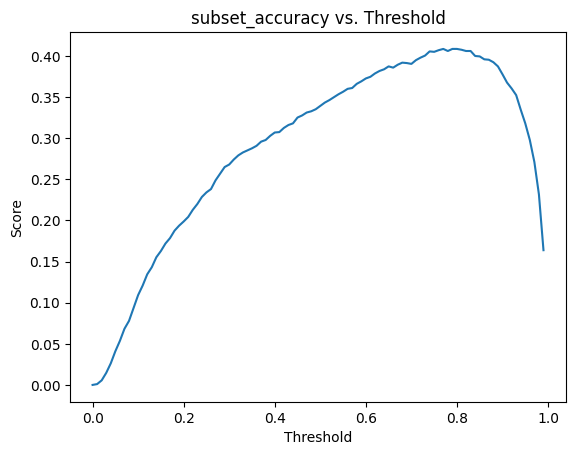

In [24]:
best_threshold = optimize_score(subset_accuracy, y_true, y_pred)

### 3.5 Optimized Threshold

In [25]:
evaluate_all(y_true, y_pred, threshold=best_threshold)

F1 Score (Macro-Average)   	0.504
F1 Score (Weighted-Average)	0.561
Average Jaccard Similarity 	0.509
Subset Accuracy            	0.409
